In [1]:
import datetime


today = datetime.datetime.now().strftime("%Y%m%d")
print(today)


20250615


### Step 1: Prepare the data

In [2]:
import pandas as pd

In [3]:
reviews_df = pd.read_csv('../02.Dataset/labeled/reviews.csv')

In [4]:
reviews_df.head()

,ProductID,CustomerID,Rating,Comment,Label
0,74021317,7991785,5,Một quyển sách hay,pos
1,187827003,18150739,5,"Mình đã từng đọc sơ nội dung sách, rất hay, rấ...",pos
2,271380890,497788,5,"Quyển sách đẹp về hình thức, nội dung mới đọc ...",pos
3,74021317,19165924,5,"Sách đẹp, hài lòng",pos
4,105483727,10170816,5,"sách đóng gói cẩn thận, giao hành nhanh",pos


In [5]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4380 entries, 0 to 4379
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ProductID   4380 non-null   int64 
 1   CustomerID  4380 non-null   int64 
 2   Rating      4380 non-null   int64 
 3   Comment     4380 non-null   object
 4   Label       4380 non-null   object
dtypes: int64(3), object(2)
memory usage: 171.2+ KB


In [6]:
reviews_df["Label"].value_counts()

Label
neg    2113
pos    1911
neu     356
Name: count, dtype: int64

In [7]:
reviews_df = reviews_df[reviews_df['Label'] != 'neu'].copy()

In [8]:
reviews_df.dropna(inplace=True)

In [9]:
print(reviews_df["Label"].unique())

['pos' 'neg']


In [10]:
reviews_df["Label"].value_counts()

Label
neg    2113
pos    1911
Name: count, dtype: int64

### Step 2: Data preprocessing

In [26]:
class TextProcessor:
    def __init__(
        self,
        teencode_path="teencode.csv",
        stopword_path="stopwords.txt",
        phrase_rules_path="phrase_rules.csv",
    ):
        self.teencode_dict = self.load_teencode_dict(teencode_path)
        self.stopwords = self.load_stopwords(stopword_path)
        self.phrase_rules = self.load_phrase_rules(phrase_rules_path)
        self.negation_prefixes = {
            "không",
            "chưa",
            "chẳng",
            "chớ",
            "chả",
            "đừng",
        }
        self.negative_indicators = {"bị", "nên", "được", "đáng", "thiếu", "mất"}

    def load_teencode_dict(self, path):
        import csv

        with open(path, mode="r", encoding="utf-8") as file:
            reader = csv.DictReader(file)
            return {row["Teencode"]: row["Meaning"] for row in reader}

    def load_stopwords(self, path):
        with open(path, "r", encoding="utf-8") as f:
            return set(line.strip().lower() for line in f if line.strip())

    def load_phrase_rules(self, path):
        import csv

        rules = {}
        with open(path, mode="r", encoding="utf-8") as file:
            reader = csv.DictReader(file)
            for row in reader:
                if row["Phrase"] and row["Normalized"]:
                    rules[row["Phrase"].strip()] = row["Normalized"].strip()
        return rules

    def clean_text(self, text):
        import re
        import string
        import emoji

        if not isinstance(text, str):
            return ""

        text = text.replace("_x000D_", " ")
        text = emoji.replace_emoji(text, replace="")
        text = re.sub(r"[:;][-~]?[)D(/\\|pP]", "", text)
        text = text.lower()
        text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)

        text = re.sub(r"(\d+)\s+([^\d\s]+)", r"\1_\2", text)

        text = text.translate(
            str.maketrans({p: " " for p in string.punctuation if p != "_"})
        )

        return text

    def normalize_teencode(self, text):
        import string

        words = text.split()
        converted_words = []
        for word in words:
            core = word.strip(string.punctuation)
            if core in self.teencode_dict:
                new_word = word.replace(core, self.teencode_dict[core])
                new_word = new_word.replace(" ", "_")
                converted_words.append(new_word)
            else:
                converted_words.append(word)
        return " ".join(converted_words)

    def normalize_repeated_chars(self, text):
        import re

        return " ".join([re.sub(r"(.)\1{1,}", r"\1", word) for word in text.split()])

    def apply_phrase_rules(self, text):
        import re

        for phrase, normalized in sorted(
            self.phrase_rules.items(), key=lambda x: len(x[0]), reverse=True
        ):
            text = re.sub(rf"\b{re.escape(phrase)}\b", normalized, text)
        return text

    def process_negations(self, text):
        words = text.split()
        result = []
        i = 0
        while i < len(words):
            # không có + từ (ví dụ: không có bọc)
            if (
              i + 2 < len(words)
              and words[i] == "không"
              and words[i + 1] == "có"
          ):
                result.append(f"{words[i]}_{words[i+1]}_{words[i+2]}")
                i += 3
            # phủ định + bị + từ (ví dụ: không bị rách)
            elif (
              i + 2 < len(words)
              and words[i] in self.negation_prefixes
              and words[i + 1] in self.negative_indicators
          ):
                result.append(f"{words[i]}_{words[i+1]}_{words[i+2]}")
                i += 3
            # phủ định + từ (ví dụ: không tốt)
            elif i + 1 < len(words) and words[i] in self.negation_prefixes:
                result.append(f"{words[i]}_{words[i+1]}")
                i += 2
            # bị/nên/... + từ (ví dụ: nên ủng_hộ)
            elif i + 1 < len(words) and words[i] in self.negative_indicators:
                result.append(f"{words[i]}_{words[i+1]}")
                i += 2
            else:
                result.append(words[i])
                i += 1
        return " ".join(result)

    def process_special_word(self, text, special_word=""):
        new_text = ""
        text_lst = text.split()
        i = 0
        if special_word in text_lst:
            while i <= len(text_lst) - 1:
                word = text_lst[i]
                if word == special_word:
                    next_idx = i + 1
                    if next_idx <= len(text_lst) - 1:
                        word = word + "_" + text_lst[next_idx]
                    i = next_idx + 1
                else:
                    i = i + 1
                new_text = new_text + word + " "
        else:
            new_text = text
        return new_text.strip()

    def tokenize(self, text):
        from pyvi import ViTokenizer

        return ViTokenizer.tokenize(text)

    def remove_stopwords(self, text):
        words = text.split()
        result = []
        i = 0
        while i < len(words):
            if i < len(words) - 1 and f"{words[i]}_{words[i+1]}" in self.stopwords:
                i += 2
                continue
            if words[i] not in self.stopwords:
                result.append(words[i])
            i += 1
        return " ".join(result)

    def preprocess(self, text):
        text = self.clean_text(text)
        text = self.normalize_teencode(text)
        text = self.normalize_repeated_chars(text)
        text = self.apply_phrase_rules(text)
        text = self.tokenize(text)
        text = self.process_negations(text)
        text = self.remove_stopwords(text)
        text = self.process_special_word(text, special_word="giao_hàng")
        text = self.process_special_word(text, special_word="giao")
        text = self.process_special_word(text, special_word="bao")
        text = self.process_special_word(text, special_word="bọc")
        text = self.process_special_word(text, special_word="bao_bọc")
        text = self.process_special_word(text, special_word="đóng_gói")
        return text

In [20]:
pre = TextProcessor(
    teencode_path="../02.Dataset/vietnamese/teencode.csv",
    stopword_path="../02.Dataset/vietnamese/stopwords.txt",
    phrase_rules_path="../02.Dataset/vietnamese/phrase_rules.csv",
)

In [13]:
reviews_df["Comment Cleaned"] = reviews_df["Comment"].apply(lambda x: pre.preprocess(x) if isinstance(x, str) else "")

reviews_df.dropna(subset=["Comment Cleaned"], inplace=True)
reviews_df = reviews_df[reviews_df["Comment Cleaned"].str.strip().str.len() >= 2]

reviews_df.reset_index(drop=True, inplace=True)

In [14]:
reviews_df.to_csv(f'../06.Log/{today}_reviews_processed.csv')

### Step 3: Split the dataset to train set and test set

In [15]:
from sklearn.model_selection import train_test_split


X = reviews_df["Comment Cleaned"]
y = reviews_df["Label"]
original_comments = reviews_df["Comment"]

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, reviews_df.index, test_size=0.3, random_state=42
)

### Step 4: Train and fit the model

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

In [17]:
from sklearn.svm import LinearSVC
text_clf_svm = Pipeline([("tfidf", TfidfVectorizer(max_features=3000, min_df=5, max_df=0.8, sublinear_tf=True)), ("clf", LinearSVC())])
text_clf_svm.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.8, max_features=3000, min_df=5,
                                 sublinear_tf=True)),
                ('clf', LinearSVC())])

### Step 5: Run predictions and analyze the results

In [18]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

predictions_svm = text_clf_svm.predict(X_test)

print("-----------------SVM-----------------")
print("Confusion matrix:\n", confusion_matrix(y_test, predictions_svm))
print()
print(f"Accuracy score: {accuracy_score(y_test, predictions_svm)}")
print()
print("Classification report:\n", classification_report(y_test, predictions_svm))

-----------------SVM-----------------
Confusion matrix:
 [[567  42]
 [ 64 528]]

Accuracy score: 0.9117402164862615

Classification report:
               precision    recall  f1-score   support

         neg       0.90      0.93      0.91       609
         pos       0.93      0.89      0.91       592

    accuracy                           0.91      1201
   macro avg       0.91      0.91      0.91      1201
weighted avg       0.91      0.91      0.91      1201



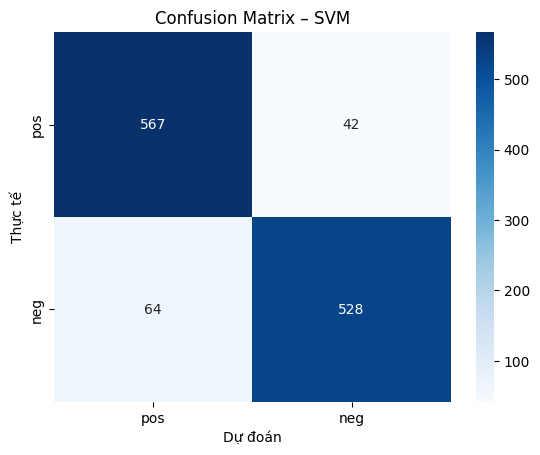

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predictions_svm)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["pos", "neg"],
    yticklabels=["pos", "neg"],
)
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.title("Confusion Matrix – SVM")
plt.savefig("confusion_matrix_svm.png")
plt.show()

In [20]:
wrong_preds_mask = y_test != predictions_svm
wrong_indices = idx_test[wrong_preds_mask]

errors_df = reviews_df.loc[
    wrong_indices, ["Comment", "Comment Cleaned", "Label"]
].copy()
errors_df["Predicted"] = pd.Series(predictions_svm, index=idx_test)[
    wrong_preds_mask
].values

errors_df.to_csv(f'../06.Log/{today}_error.csv')

print("========= Những bình luận dự đoán sai =========")
print(errors_df.head(10))

========= Những bình luận dự đoán sai =========
                                                Comment  \
3151  giao hàng rất nhanh, sách thì hay đấy nhưng dị...   
2973  Nội dung của sách như các bài báo về tips nuôi...   
314                                đọc mà khóc luôn :((   
889           Sách đọc hơi có nhiều thuật ngữ trừ tượng   
555   2 cuốn này thì siêu hot rồi, mỗi sáng thức dậy...   
721   Sách của Nhã Nam rất đẹp, lỗi in thì có thể li...   
354   mua bên tiki sách lúc nào cũng giao đúng ngày ...   
1764  Sách về siêu nhanh nhưng cách gói hàng ẩu xỉu!...   
752   Thay nếp nghĩ, thói quen, cách sống sẽ Đổi cuộ...   
179                                             ❤️16-02   

                                        Comment Cleaned Label Predicted  
3151               giao_hàng_nhanh sách hay đấy dịch_dở   neg       pos  
2973  nội_dung sách báo tips nuôi dạy chưa_đi_sâu nê...   neg       pos  
314                                            đọc khóc   pos       neg  
889   

### Step 6: Save the model

In [23]:
import joblib

joblib.dump(text_clf_svm, f"../05.Models/{today}_sentiment_analysis_model.pkl")

['../05.Models/20250615_sentiment_analysis_model.pkl']

### TEST

In [28]:
pre = TextProcessor(
    teencode_path="../02.Dataset/vietnamese/teencode.csv",
    stopword_path="../02.Dataset/vietnamese/stopwords.txt",
    phrase_rules_path="../02.Dataset/vietnamese/phrase_rules.csv",
)

import joblib
import numpy as np

sentiment_analysis_model = joblib.load(
    "../05.Models/20250615_sentiment_analysis_model.pkl"
)

In [30]:
test_data = [
    "Một quyển sách hay",
    "đóng gói kh cẩn thận",
    "Sách đẹp, hài lòng",
    "Ok sách đẹp",
    "Rất hayy"
]

In [29]:
pre.normalize_repeated_chars("hayy")

'hay'

In [31]:
# Predict labels
predictions = sentiment_analysis_model.predict([pre.preprocess(text) for text in test_data])

preprocessed_data = ["".join(pre.preprocess(text)) for text in test_data]

# Display each text with predicted label using lambda and zip
list(
    map(
        lambda x: print(
            f"📝 Original: {x[0]}\n🧹 Preprocessed: {x[1]}\n🔖 Predicted label: {x[2]}\n"
        ),
        zip(test_data, preprocessed_data, predictions),
    )
)

📝 Original: Một quyển sách hay
🧹 Preprocessed: quyển_sách hay
🔖 Predicted label: pos

📝 Original: đóng gói kh cẩn thận
🧹 Preprocessed: đóng_gói_không_cẩn_thận
🔖 Predicted label: neg

📝 Original: Sách đẹp, hài lòng
🧹 Preprocessed: sách_đẹp hài_lòng
🔖 Predicted label: pos

📝 Original: Ok sách đẹp
🧹 Preprocessed: ổn sách_đẹp
🔖 Predicted label: pos

📝 Original: Rất hayy
🧹 Preprocessed: hay
🔖 Predicted label: pos



[None, None, None, None, None]